https://www.kaggle.com/code/daniilkrasnoproshin/ps-s4e6-ensemble-learning/notebook

## 1- Initial Data Load

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import plotly.express as px
%matplotlib inline
plt.style.use('fivethirtyeight')

import optuna

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier, VotingClassifier, RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_validate, cross_val_predict, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SequentialFeatureSelector

In [3]:
train_df = pd.read_csv("Academic Train.csv")
test_df = pd.read_csv("Academic Test.csv")

In [4]:
train_df.sample(8)

id  Marital status  Application mode  Application order  Course  \
11203  11203               1                44                  1     171   
32841  32841               1                 1                  1    9085   
28038  28038               1                 1                  1    9500   
1501    1501               1                39                  2    9238   
15765  15765               1                17                  3    9773   
29229  29229               1                 1                  1    9500   
10408  10408               1                 1                  4    9500   
64666  64666               2                39                  2    8014   

       Daytime/evening attendance  Previous qualification  \
11203                           1                      39   
32841                           1                       1   
28038                           1                       1   
1501                            1                      12   
15765                           1                       1   
29229                           1                       1   
10408                           1                       1   
64666                           0                      19   

       Previous qualification (grade)  Nacionality  Mother's qualification  \
11203                           160.0            1                      19   
32841                           129.0            1                      38   
28038                           137.0            1                       1   
1501                            133.1            1                      38   
15765                           160.0            1                      38   
29229                           136.0            1                       1   
10408                           137.0            1                      38   
64666                           130.0            1                      37   

       ...  Curricular units 2nd sem (credited)  \
11203  ...                                    0   
32841  ...                                    0   
28038  ...                                    0   
1501   ...                                    0   
15765  ...                                    0   
29229  ...                                    0   
10408  ...                                    0   
64666  ...                                    1   

       Curricular units 2nd sem (enrolled)  \
11203                                    0   
32841                                    5   
28038                                    7   
1501                                     6   
15765                                    6   
29229                                    8   
10408                                    7   
64666                                    6   

       Curricular units 2nd sem (evaluations)  \
11203                                       0   
32841                                       5   
28038                                       8   
1501                                       13   
15765                                       6   
29229                                      11   
10408                                       7   
64666                                       7   

       Curricular units 2nd sem (approved)  Curricular units 2nd sem (grade)  \
11203                                    0                          0.000000   
32841                                    5                         12.600000   
28038                                    7                         11.400000   
1501                                     4                         13.250000   
15765                                    6                         15.166667   
29229                                    6                         13.683333   
10408                                    6                         12.000000   
64666                                    6                         13.166667   

       Curricular units 2

In [5]:
train_df.isna().sum().sort_values(ascending = False)

id                                                0
Curricular units 2nd sem (credited)               0
International                                     0
Curricular units 1st sem (credited)               0
Curricular units 1st sem (enrolled)               0
Curricular units 1st sem (evaluations)            0
Curricular units 1st sem (approved)               0
Curricular units 1st sem (grade)                  0
Curricular units 1st sem (without evaluations)    0
Curricular units 2nd sem (enrolled)               0
Marital status                                    0
Curricular units 2nd sem (evaluations)            0
Curricular units 2nd sem (approved)               0
Curricular units 2nd sem (grade)                  0
Curricular units 2nd sem (without evaluations)    0
Unemployment rate                                 0
Inflation rate                                    0
GDP                                               0
Age at enrollment                                 0
Scholarship 

In [6]:
train_df.duplicated().sum()

0

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76518 entries, 0 to 76517
Data columns (total 38 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   id                                              76518 non-null  int64  
 1   Marital status                                  76518 non-null  int64  
 2   Application mode                                76518 non-null  int64  
 3   Application order                               76518 non-null  int64  
 4   Course                                          76518 non-null  int64  
 5   Daytime/evening attendance                      76518 non-null  int64  
 6   Previous qualification                          76518 non-null  int64  
 7   Previous qualification (grade)                  76518 non-null  float64
 8   Nacionality                                     76518 non-null  int64  
 9   Mother's qualification                 

In [8]:
train_df.describe()

id  Marital status  Application mode  Application order  \
count  76518.000000    76518.000000      76518.000000       76518.000000   
mean   38258.500000        1.111934         16.054419           1.644410   
std    22088.988286        0.441669         16.682337           1.229645   
min        0.000000        1.000000          1.000000           0.000000   
25%    19129.250000        1.000000          1.000000           1.000000   
50%    38258.500000        1.000000         17.000000           1.000000   
75%    57387.750000        1.000000         39.000000           2.000000   
max    76517.000000        6.000000         53.000000           9.000000   

             Course  Daytime/evening attendance  Previous qualification  \
count  76518.000000                76518.000000            76518.000000   
mean    9001.286377                    0.915314                3.658760   
std     1803.438531                    0.278416                8.623774   
min       33.000000                    0.000000                1.000000   
25%     9119.000000                    1.000000                1.000000   
50%     9254.000000                    1.000000                1.000000   
75%     9670.000000                    1.000000                1.000000   
max     9991.000000                    1.000000               43.000000   

       Previous qualification (grade)   Nacionality  Mother's qualification  \
count                    76518.000000  76518.000000            76518.000000   
mean                       132.378766      1.226600               19.837633   
std                         10.995328      3.392183               15.399456   
min                         95.000000      1.000000                1.000000   
25%                        125.000000      1.000000                1.000000   
50%                        133.100000      1.000000               19.000000   
75%                        140.000000      1.000000               37.000000   
max                        190.000000    109.000000               44.000000   

       ...  Curricular units 1st sem (without evaluations)  \
count  ...                                     76518.00000   
mean   ...                                         0.05796   
std    ...                                         0.40849   
min    ...                                         0.00000   
25%    ...                                         0.00000   
50%    ...                                         0.00000   
75%    ...                                         0.00000   
max    ...                                        12.00000   

       Curricular units 2nd sem (credited)  \
count                         76518.000000   
mean                              0.137053   
std                               0.933830   
min                               0.000000   
25%                               0.000000   
50%                               0.000000   
75%                               0.000000   
max                              19.000000   

       Curricular units 2nd sem (enrolled)  \
count                         76518.000000   
mean                              5.933414   
std                               1.627182   
min                               0.000000   
25%                               5.000000   
50%                               6.000000   
75%                               6.000000   
max                              23.000000   

       Curricular units 2nd sem (evaluations)  \
count                            76518.000000   
mean                                 7.234468   
std                                  3.503040   
min                                  0.000000   
25%                                  6.000000   
50%                                  7.000000   
75%                                  9.000000   
max                                 33.000000   

       Curricular units 2nd sem (approved)  Curricular units 2nd sem (grade)  \
count                         765

## 2- EDA

In [9]:
train_df.drop(columns = ["id", "Application mode", "Application order"], inplace = True)
test_df.drop(columns = ["id", "Application mode", "Application order"], inplace = True)

In [10]:
print(train_df.shape)
print(test_df.shape)

(76518, 35)
(51012, 34)


In [11]:
for col in train_df.columns:
    print(f"{col} has {train_df[col].nunique()} values")

Marital status has 6 values
Course has 19 values
Daytime/evening attendance has 2 values
Previous qualification has 21 values
Previous qualification (grade) has 110 values
Nacionality has 18 values
Mother's qualification has 35 values
Father's qualification has 39 values
Mother's occupation has 40 values
Father's occupation has 56 values
Admission grade has 668 values
Displaced has 2 values
Educational special needs has 2 values
Debtor has 2 values
Tuition fees up to date has 2 values
Gender has 2 values
Scholarship holder has 2 values
Age at enrollment has 46 values
International has 2 values
Curricular units 1st sem (credited) has 21 values
Curricular units 1st sem (enrolled) has 24 values
Curricular units 1st sem (evaluations) has 36 values
Curricular units 1st sem (approved) has 23 values
Curricular units 1st sem (grade) has 1206 values
Curricular units 1st sem (without evaluations) has 12 values
Curricular units 2nd sem (credited) has 20 values
Curricular units 2nd sem (enrolled) 

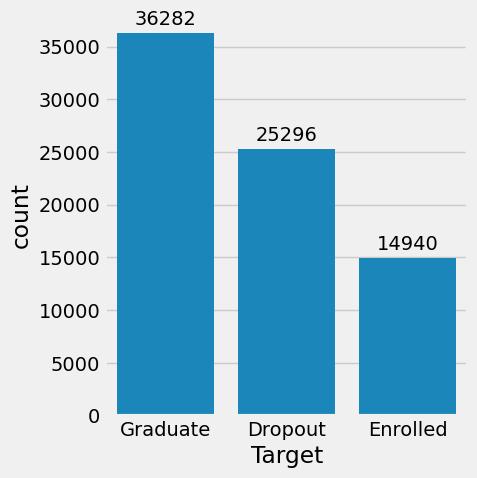

In [12]:
plt.figure(figsize = (5, 5))
ax = sns.countplot(x = train_df["Target"])

for container in ax.containers:
    ax.bar_label(container, label_type = "edge", padding = 3)

plt.xticks(rotation = 0)
plt.tight_layout()
plt.show()

In [13]:
numerical_cols = ['Admission grade', 
               'Age at enrollment', 
               'Curricular units 1st sem (credited)',
               'Curricular units 1st sem (enrolled)',
               'Curricular units 1st sem (evaluations)',
               'Curricular units 1st sem (approved)',
               'Curricular units 1st sem (grade)',
               'Curricular units 1st sem (without evaluations)',
               'Curricular units 2nd sem (credited)',
               'Curricular units 2nd sem (enrolled)',
               'Curricular units 2nd sem (evaluations)',
               'Curricular units 2nd sem (approved)',
               'Curricular units 2nd sem (grade)',
               'Curricular units 2nd sem (without evaluations)',
               'Unemployment rate',
               'Inflation rate',
               'GDP']
len(numerical_cols)

17

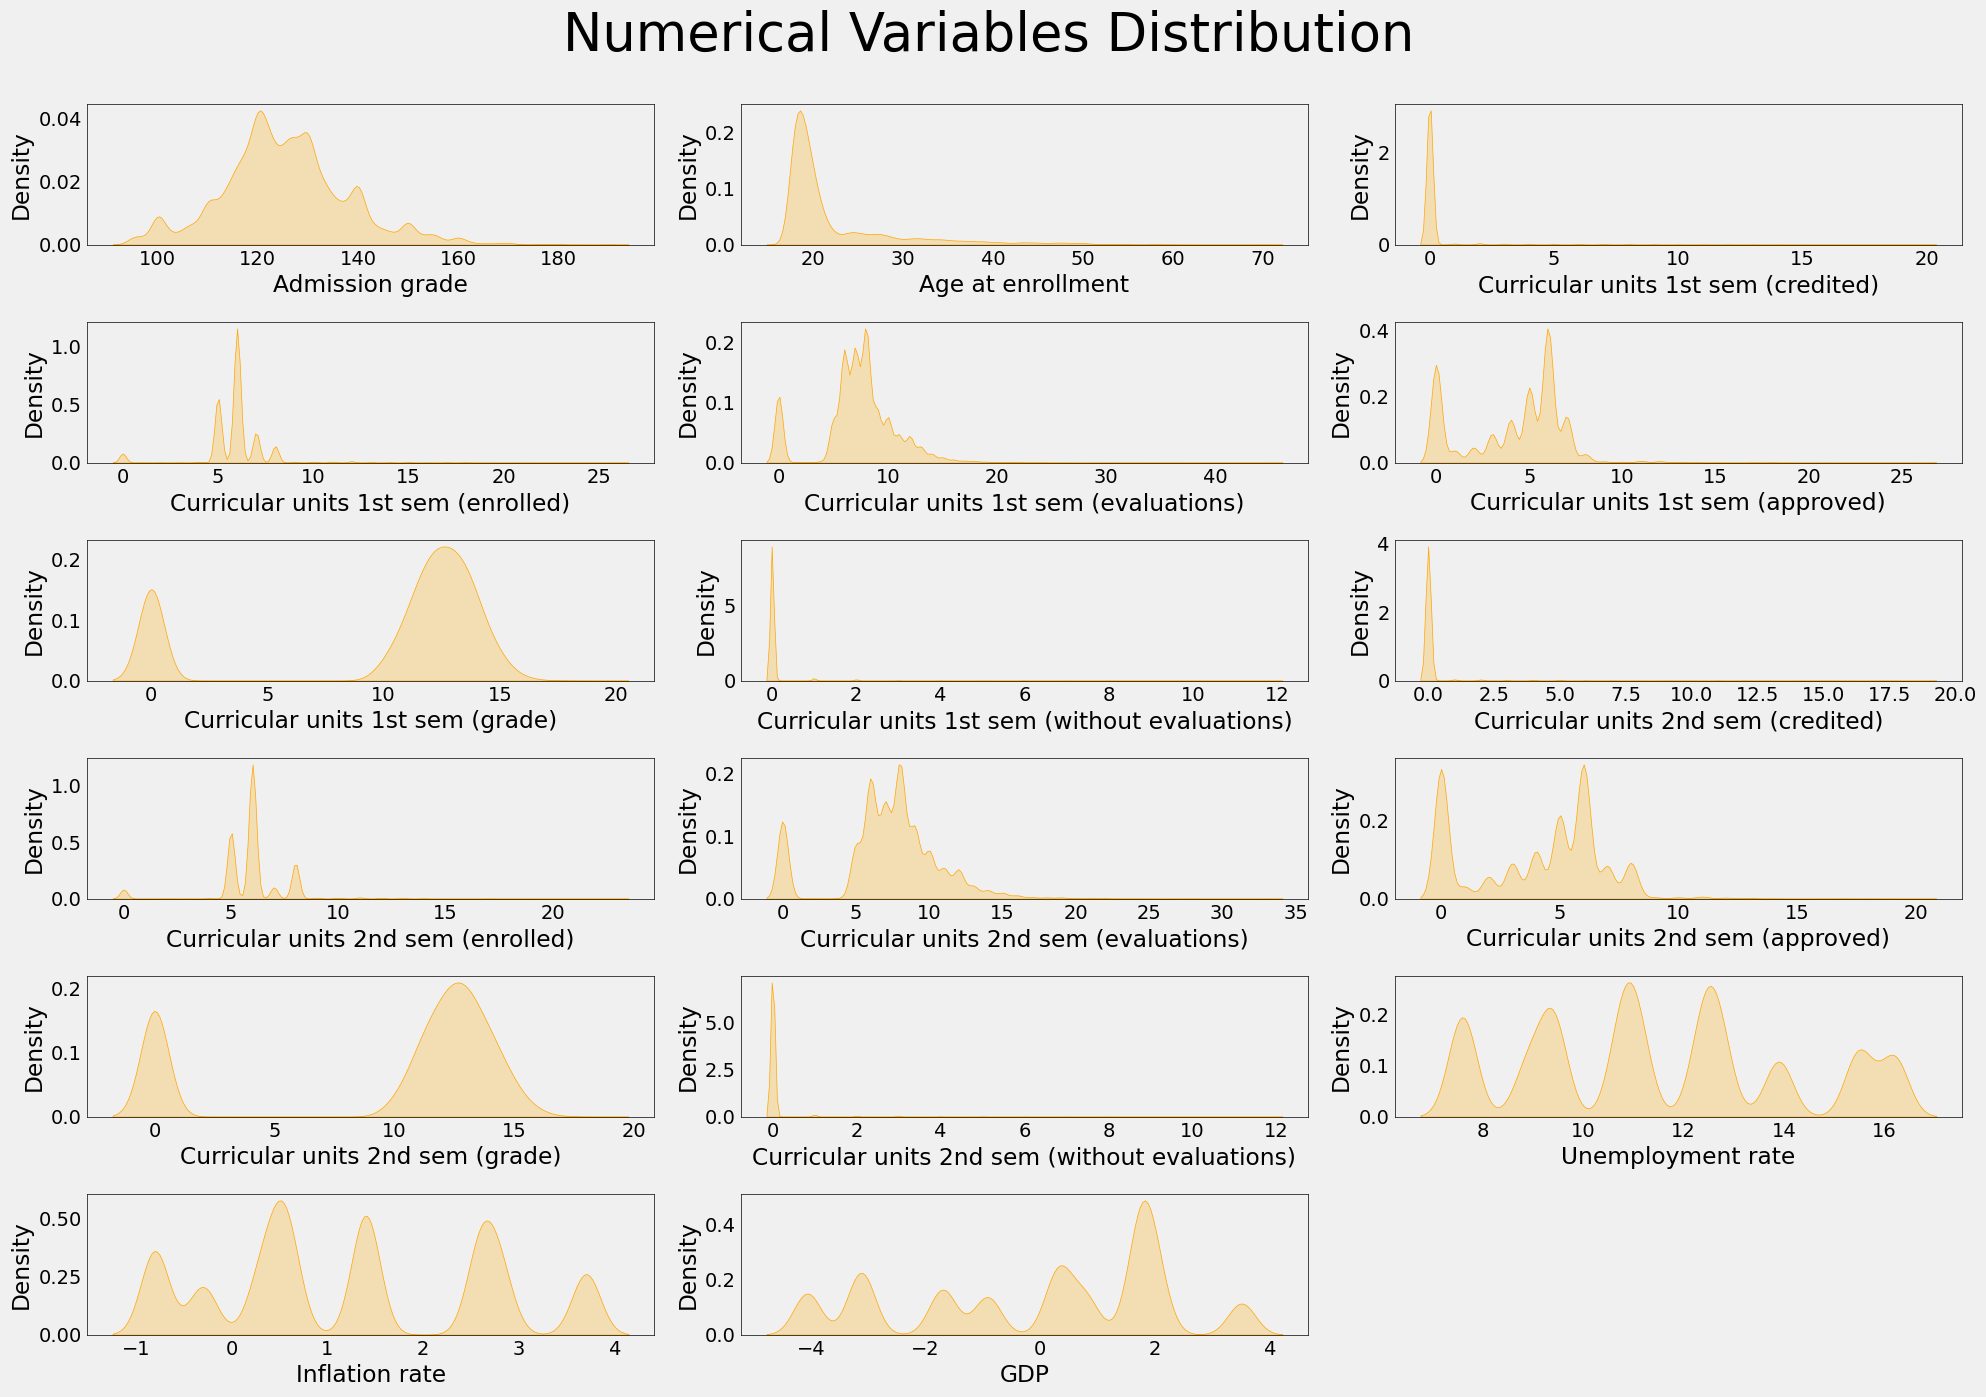

In [14]:
plt.figure(figsize = (20, 20))
plot_number = 1
for col in numerical_cols:
    if plot_number <= len(numerical_cols):
        ax = plt.subplot(9, 3, plot_number)
        sns.kdeplot(train_df[col], color='orange', fill=True)
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_color('black')
            spine.set_linewidth(0.5)
        plt.xlabel(col)
        ax.grid(False)
        
    plot_number += 1
plt.suptitle('Numerical Variables Distribution', fontsize=38, y=1)
plt.tight_layout()
plt.show()

In the context of matplotlib plots, a spine refers to the border around the axes of a subplot. It's essentially the line that outlines the plot area. Each subplot typically has four spines: top, bottom, left, and right.

Here's a breakdown of the spines:

- **Top spine**: Located at the top of the subplot.
- **Bottom spine**: Located at the bottom of the subplot.
- **Left spine**: Located at the left side of the subplot.
- **Right spine**: Located at the right side of the subplot.

These spines help define the boundaries of the plot and are used to frame the data area. They can be customized in terms of visibility, color, and line width to enhance the appearance of the plot or to emphasize certain aspects of the data visualization.

### Manipulating Spines in Matplotlib:

You can access and manipulate the spines of a subplot in Matplotlib using the `spines` attribute of an axes object (`ax`). For example:

- **Accessing spines**: `ax.spines` gives you a dictionary-like object where each key is a spine (`'top'`, `'bottom'`, `'left'`, `'right'`) and the corresponding value is a `matplotlib.spines.Spine` object.
  
- **Customizing spines**: You can customize spines by setting properties like visibility (`set_visible()`), color (`set_color()`), and line width (`set_linewidth()`).

Here’s an example of how you might customize the spines in Matplotlib:

```python
import matplotlib.pyplot as plt

# Example plot
fig, ax = plt.subplots()

# Hide the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Set the color and linewidth of the remaining spines
ax.spines['bottom'].set_color('blue')
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_color('green')
ax.spines['left'].set_linewidth(0.8)

# Plotting example data
x = [1, 2, 3, 4]
y = [1, 4, 9, 16]
ax.plot(x, y)

plt.show()
```

In this example:
- `ax.spines['top'].set_visible(False)` and `ax.spines['right'].set_visible(False)` hide the top and right spines.
- `ax.spines['bottom'].set_color('blue')` and `ax.spines['left'].set_color('green')` change the color of the bottom and left spines.
- `ax.spines['bottom'].set_linewidth(1.5)` and `ax.spines['left'].set_linewidth(0.8)` adjust the line widths of the bottom and left spines, respectively.

Customizing spines allows you to refine the appearance of your plots and highlight specific aspects of your data visualization.

In the context of plotting and visualization libraries like Matplotlib, "linewidth" (often abbreviated as "lw") refers to the thickness of lines used in plots. It determines how thick or thin lines appear when they are drawn on a plot.

When you specify a linewidth for a line or a border (such as the spines in a plot), you are controlling the visual weight of that line. Thicker lines are more prominent and can stand out more in a plot, while thinner lines are more subtle.

### How linewidth is used:

- **Setting linewidth in plots**: In Matplotlib, you can set the linewidth directly when plotting lines, scatter plots, or when customizing elements like spines.
  
  ```python
  import matplotlib.pyplot as plt
  
  # Example plot with customized linewidth
  fig, ax = plt.subplots()
  
  # Plotting with a specific linewidth
  ax.plot([1, 2, 3, 4], [1, 4, 9, 16], linewidth=2.5)  # Set linewidth to 2.5
  
  plt.show()
  ```

- **Adjusting linewidth for spines**: When customizing spines in Matplotlib, you can adjust the linewidth to change how prominent the frame of the plot appears.

  ```python
  import matplotlib.pyplot as plt
  
  fig, ax = plt.subplots()
  
  # Customize the left spine with a thicker linewidth
  ax.spines['left'].set_linewidth(1.5)
  
  plt.show()
  ```

In both cases, specifying a higher value for linewidth results in thicker lines, while lower values produce thinner lines. This parameter is useful for adjusting the visual emphasis of elements in your plots to suit your presentation or analysis needs.

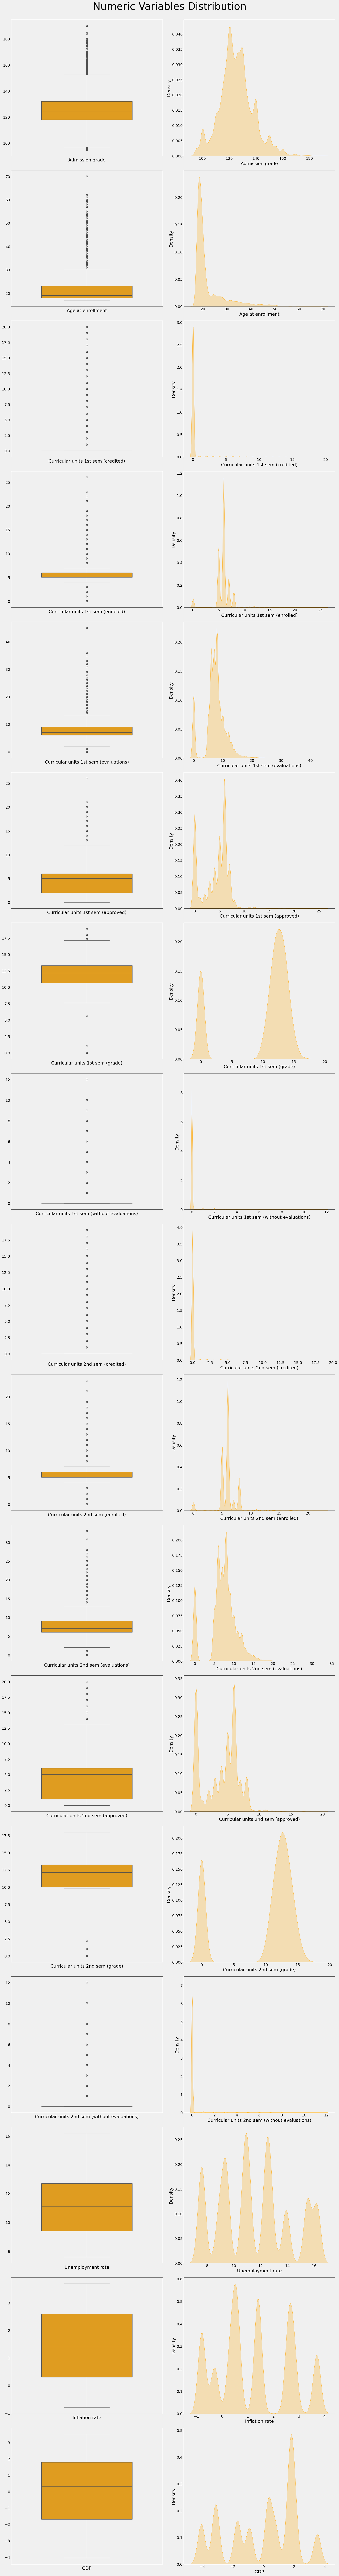

In [15]:
plt.figure(figsize = (18, 135))
plot_number = 1
for col in numerical_cols:
    if plot_number <= len(numerical_cols):

        ax1 = plt.subplot(len(numerical_cols), 2, 2 * plot_number)
        sns.kdeplot(train_df[col], color = "orange", fill = True)
        for spine in ax1.spines.values():
            spine.set_visible(True)
            spine.set_color('black')
            spine.set_linewidth(0.5)
        ax1.set_xlabel(col)
        ax1.grid(False)

        ax2 = plt.subplot(len(numerical_cols), 2, 2 * plot_number - 1)
        sns.boxplot(y=train_df[col], color='orange', width=0.6, linewidth=1)
        for spine in ax2.spines.values():
            spine.set_visible(True)
            spine.set_color('black')
            spine.set_linewidth(0.5)
        ax2.set_xlabel(col)
        ax2.set_ylabel('')
        ax2.grid(False)
        plot_number += 1

plt.suptitle('Numeric Variables Distribution', fontsize=38, y=1)
plt.tight_layout()
plt.show()

In [16]:
categorical_cols = ['Marital status', 
               'Application mode', 
               'Application order', 
               'Daytime/evening attendance',
               'Previous qualification', 
               'Nacionality', 
               "Mother's qualification",
               "Father's qualification", 
               "Mother's occupation", 
               "Father's occupation", 
               'Displaced',
               'Educational special needs', 
               'Debtor', 
               'Tuition fees up to date', 
               'Gender',
               'Scholarship holder', 
               'International']
len(categorical_cols)

17

In [17]:
# Map target variables to nums
train_df['Target'] = train_df['Target'].map({'Graduate': 0, 'Dropout': 1, 'Enrolled': 2})

In [18]:
train_df['Target']

0        0
1        1
2        1
3        2
4        0
        ..
76513    0
76514    0
76515    2
76516    1
76517    0
Name: Target, Length: 76518, dtype: int64

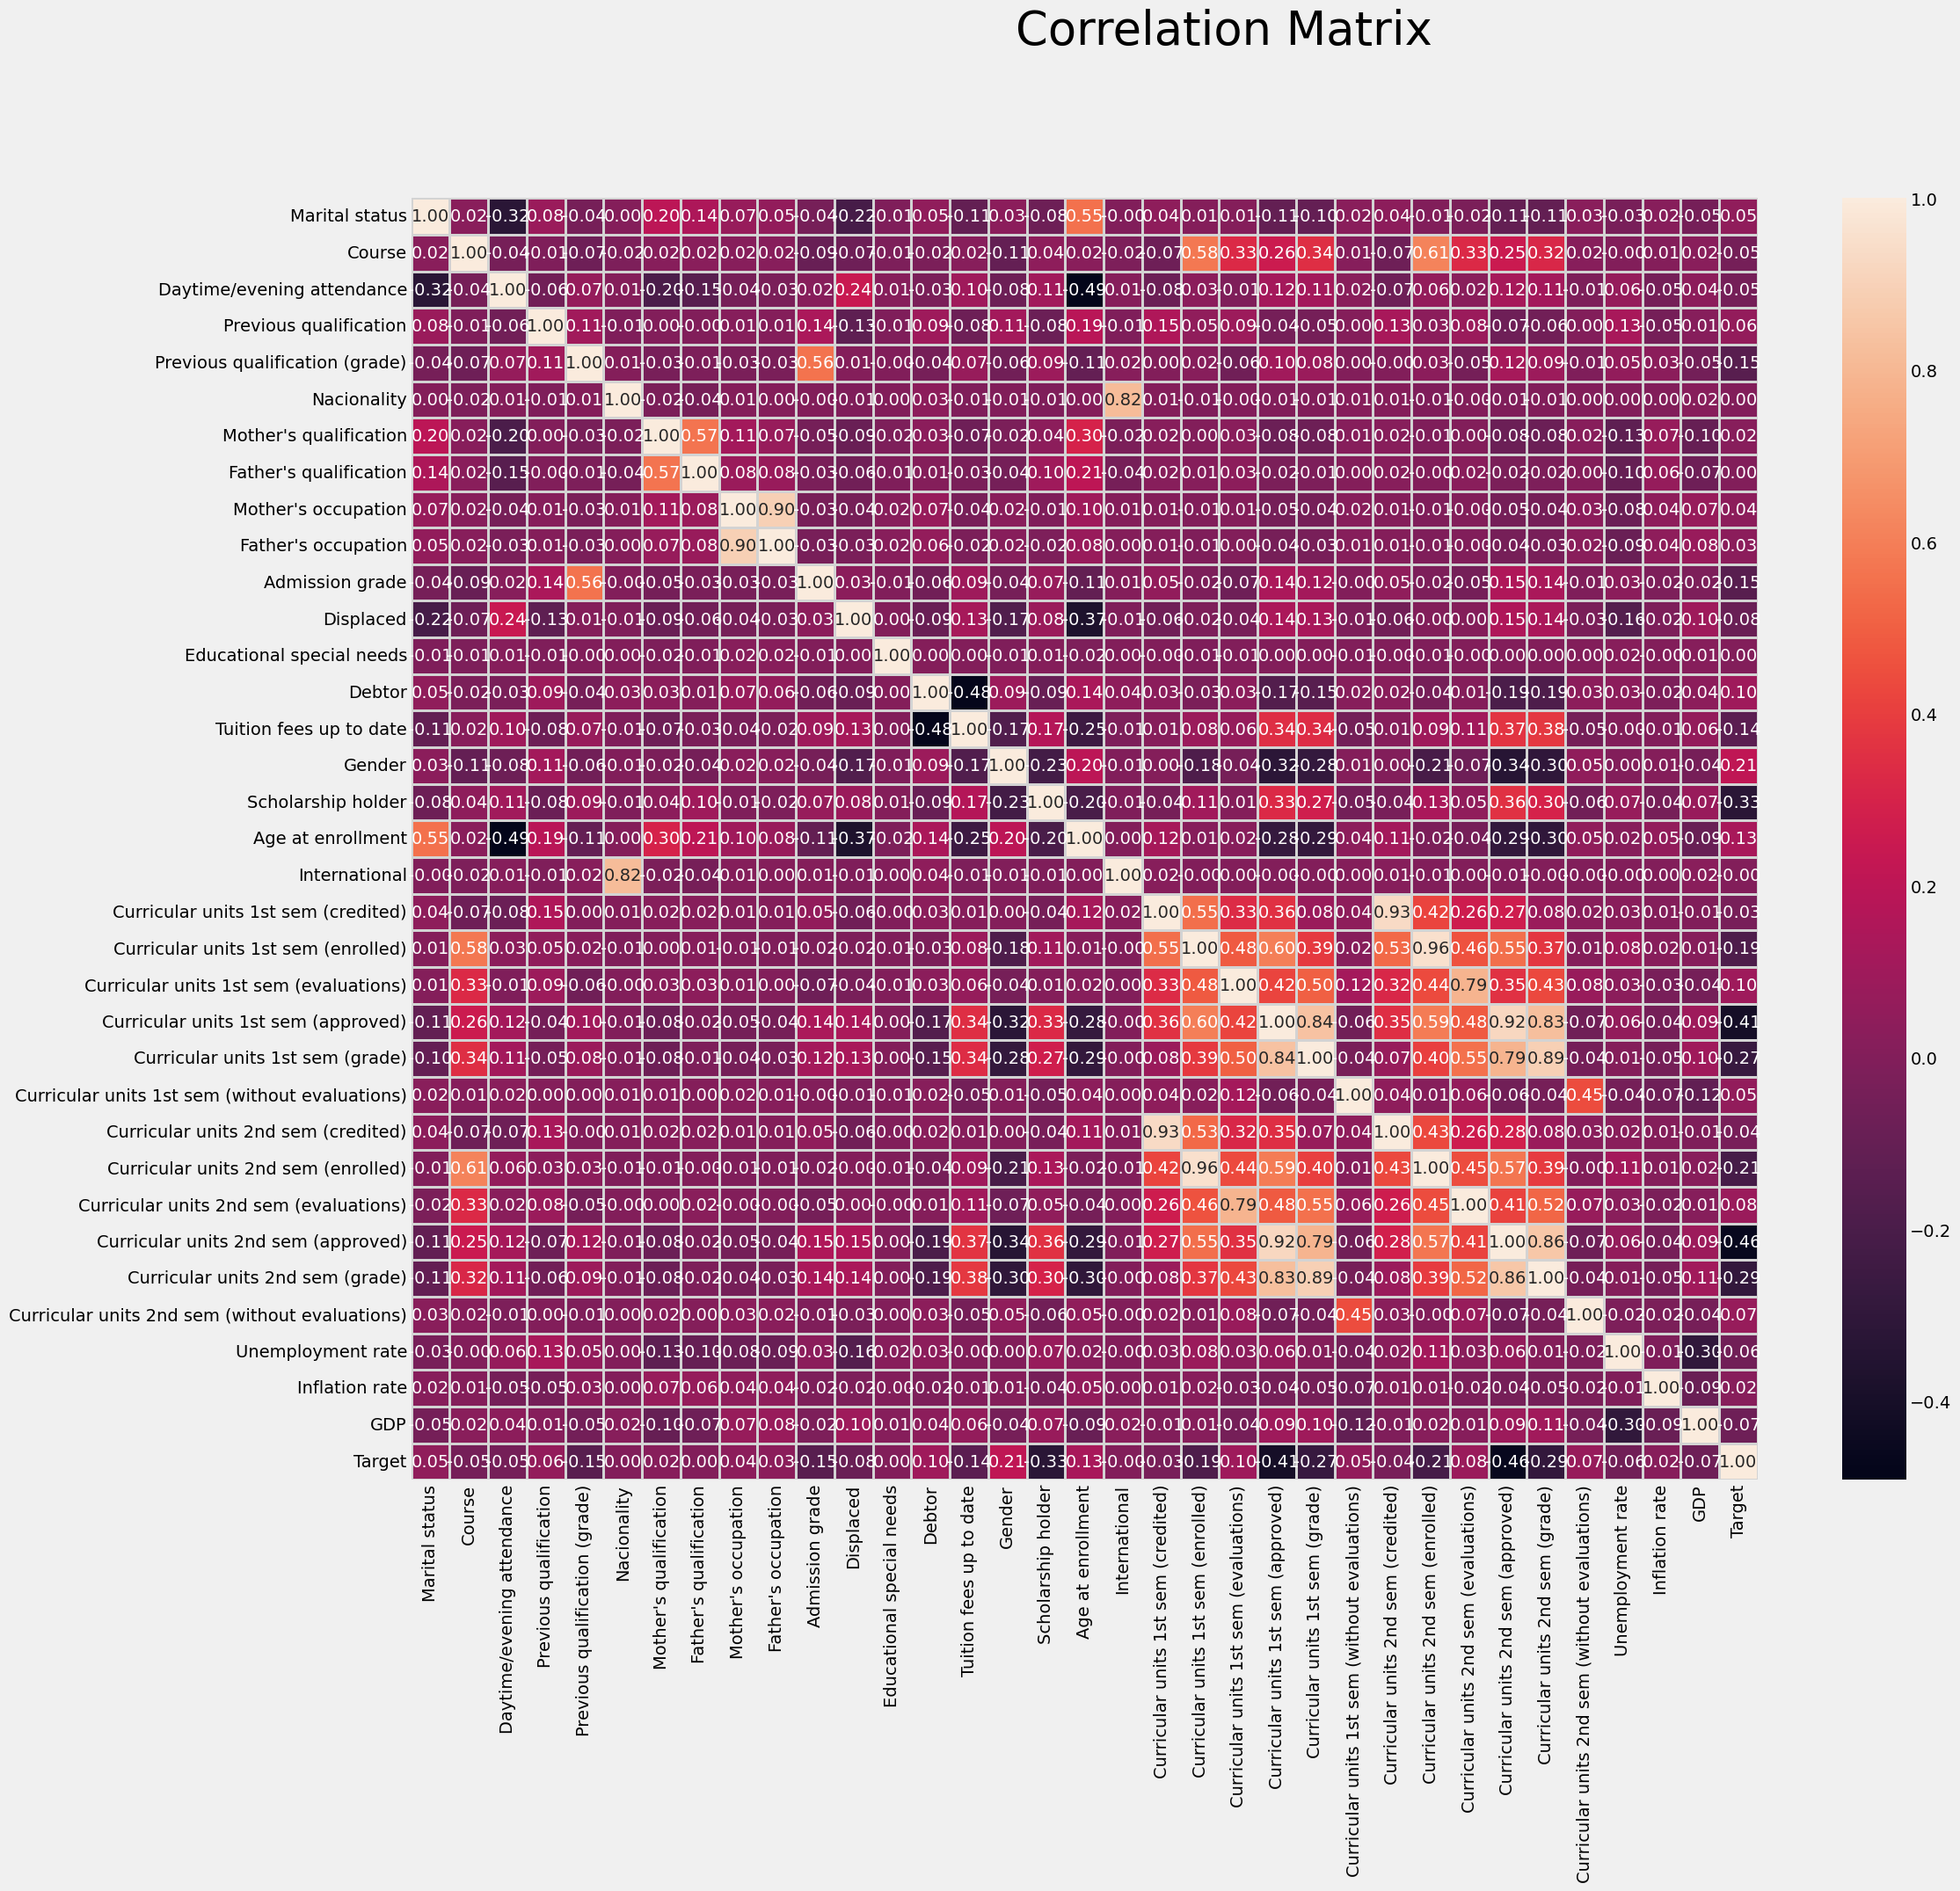

In [19]:
plt.figure(figsize = (22, 18))
sns.heatmap(train_df.corr(), annot = True, fmt = ".2f", linewidths = 2, linecolor = "lightgrey")
plt.suptitle("Correlation Matrix", fontsize = 38, y = 1)
plt.show()

In [20]:
def handle_missing_numerical_value(df):
    numerical_cols = df.select_dtypes(include = [np.number]).columns.to_list()
    df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].median())
    return df

def handle_categorical_variables(df):
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    categorical_cols = [col for col in categorical_cols if col != "Target"]
    df = pd.get_dummies(df, categorical_cols)
    return df

def apply_data_preprocessing(df, is_train=True, epsilon=1e-5):
    df.drop(columns = ["Nacionality", "International"], inplace = True)
    df["curricular_units_product"] = df["Curricular units 1st sem (enrolled)"] * df["Curricular units 2nd sem (enrolled)"]
    
    df["approved_enrolled_1st_sem_ratio"] = (df["Curricular units 1st sem (approved)"] + epsilon) / (df["Curricular units 1st sem (enrolled)"] + epsilon)
    
    df["approved_enrolled_2nd_sem_ratio"] = (df["Curricular units 2nd sem (approved)"] + epsilon) / (df["Curricular units 2nd sem (enrolled)"] + epsilon)

    df["grades_total"] = df["Curricular units 1st sem (grade)"] + df["Curricular units 2nd sem (grade)"]
    df['grades_total'] = df['Curricular units 1st sem (grade)'] + df['Curricular units 2nd sem (grade)']
    
    
    df['inflation_gdp_ratio'] = (df['Inflation rate'] + epsilon) / (df['GDP'] + epsilon)
    df['unemployment_gdp_ratio'] = (df['Unemployment rate'] + epsilon) / (df['GDP'] + epsilon)
    df['gdp_inflation_interaction'] = df['GDP'] * df['Inflation rate']
    
    df['parents_qualification_interaction'] = (df['Mother\'s qualification'] * df['Father\'s qualification'])
    
    # interaction between age at enrollment and scholarship
    df['age_scholarship_interaction'] = (df['Age at enrollment'] * df['Scholarship holder'])

    
    # academic performance
    df['total_academic_performance'] = (df['Previous qualification (grade)'] + df['Admission grade'])
    
    # total number of failed units
    df['failed_curricular_units_1st_sem'] = df['Curricular units 1st sem (approved)'] - df['Curricular units 1st sem (credited)']
    df['failed_curricular_units_2nd_sem'] = df['Curricular units 2nd sem (approved)'] - df['Curricular units 2nd sem (credited)']
        
    df = handle_missing_numerical_value(df)
    df = handle_categorical_variables(df)
    
    if is_train:
        target = df.pop('Target')
        return df, target
    else:
        return df

In [21]:
cols = ["Curricular units 1st sem (enrolled)", "Curricular units 2nd sem (enrolled)", "Curricular units 1st sem (approved)", 
            "Curricular units 2nd sem (approved)", "Curricular units 1st sem (grade)", "Curricular units 2nd sem (grade)",
           'Inflation rate', "GDP", 'Unemployment rate', 'Mother\'s qualification', 'Father\'s qualification', 'Age at enrollment',
            'Scholarship holder']

df_train, y_train = apply_data_preprocessing(train_df, is_train=True)
df_train.drop(columns = cols, inplace = True)
df_test = apply_data_preprocessing(test_df, is_train=False)
df_test.drop(columns = cols, inplace = True)

In [22]:
X_train, X_test, y_train_new, y_test = train_test_split(df_train, y_train, test_size=0.3, shuffle=True, random_state=42)

In [23]:
y_train_array = np.array(y_train)

unique_classes = np.unique(y_train_array)

unique_classes_list = list(unique_classes)

class_weights = compute_class_weight(class_weight = "balanced", classes = unique_classes, y = y_train)

In [24]:
class_weights_dict = dict(zip(unique_classes_list, class_weights))
class_weights_dict

{0: 0.7029932197784026, 1: 1.0083017077798861, 2: 1.7072289156626506}

In [25]:
base_xgb = XGBClassifier(random_state = 42)
base_xgb.fit(X_train, y_train_new)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [26]:
base_xgb_val_preds = base_xgb.predict(X_test)
base_xgb_val_accuracy = accuracy_score(y_test, base_xgb_val_preds)
print(base_xgb_val_accuracy)

0.8341174420630771


In [27]:
from sklearn.metrics import confusion_matrix

<Axes: >

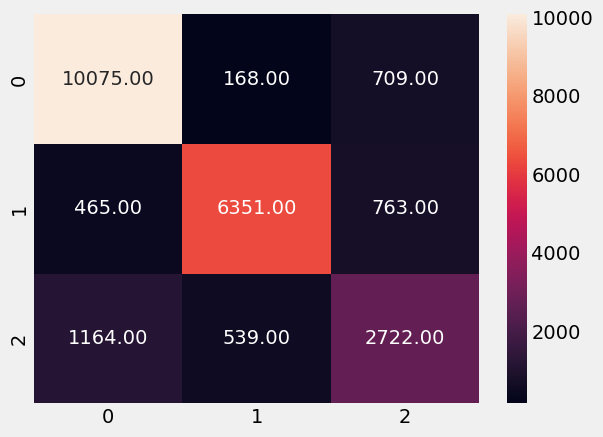

In [28]:
sns.heatmap(confusion_matrix(y_test, base_xgb_val_preds), annot = True, fmt = ".2f")

[I 2024-07-15 16:24:09,894] A new study created in memory with name: no-name-91d2db4f-2007-4b42-bc0d-0073edfd9aec
E:\Anaconda\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:24:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-07-15 16:25:14,514] Trial 0 finished with value: 0.8220073183481442 and parameters: {'max_depth': 5, 'n_estimators': 4841, 'gamma': 0.006383455688448558, 'reg_alpha': 0.02344090489732087, 'reg_lambda': 0.7430544057000437, 'min_child_weight': 1, 'subsample': 0.827030914958536, 'colsample_bytree': 0.6325435027542883, 'learning_rate': 0.08995871326140721}. Best is trial 0 with value: 0.8220073183481442.
E:\Anaconda\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:25:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\x

Best Hyperparameters: {'max_depth': 5, 'n_estimators': 2564, 'gamma': 0.7013863010621975, 'reg_alpha': 0.11921094098955098, 'reg_lambda': 0.6852510793008588, 'min_child_weight': 1, 'subsample': 0.791839015856105, 'colsample_bytree': 0.6575200652975721, 'learning_rate': 0.02601753720598146}


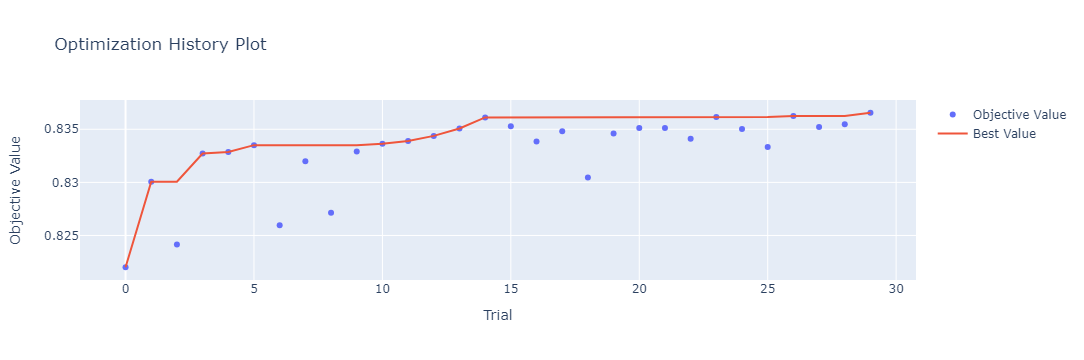

In [29]:
def objective(trial):
    max_depth = trial.suggest_int('max_depth', 5, 15)
    n_estimators = trial.suggest_int('n_estimators', 500, 5000)
    gamma = trial.suggest_float('gamma', 0, 1)
    reg_alpha = trial.suggest_float('reg_alpha', 0, 1)
    reg_lambda = trial.suggest_float('reg_lambda', 0, 1)
    min_child_weight = trial.suggest_int('min_child_weight', 0, 10)
    subsample = trial.suggest_float('subsample', 0.5, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1)
    
    
    params = {
        'n_estimators': n_estimators,
        'learning_rate': learning_rate,
        'gamma': gamma,
        'reg_alpha': reg_alpha,
        'reg_lambda': reg_lambda,
        'max_depth': max_depth,
        'min_child_weight': min_child_weight,
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'eval_metric': 'merror'
    }
    
    model = XGBClassifier(**params, class_weight=class_weights_dict)
    # model = XGBClassifier(**params)
    
    model.fit(X_train, y_train_new)
    
    # Evaluate the model on the testing data
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    
    return acc

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)
best_params = study.best_params
print("Best Hyperparameters:", best_params)
optuna.visualization.plot_optimization_history(study)

In [30]:
best_params_xgb_current = {
    'max_depth': 6, 'n_estimators': 4937, 'gamma': 0.8644097106882519, 'reg_alpha': 0.4215206295140813,
                           'reg_lambda': 0.6203345757486959,
                           'min_child_weight': 9, 'subsample': 0.8694499955731673,
                           'colsample_bytree': 0.5841425315961482, 'learning_rate': 0.02302515234749565
}

In [31]:
tuned_xgb_model = XGBClassifier(**best_params_xgb_current, eval_metric='merror', class_weight=class_weights_dict, random_state=42)

In [32]:
tuned_xgb_model.fit(X_train, y_train_new)

E:\Anaconda\Lib\site-packages\xgboost\core.py:160: UserWarning:

[16:41:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "class_weight" } are not used.




XGBClassifier(base_score=None, booster=None, callbacks=None,
              class_weight={0: 0.7029932197784026, 1: 1.0083017077798861,
                            2: 1.7072289156626506},
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5841425315961482, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='merror', feature_types=None,
              gamma=0.8644097106882519, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.02302515234749565,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=9, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=4937, n_jobs=None,
              num_parallel_tree=None, ...)

In [33]:
tuned_xgb_val_preds = tuned_xgb_model.predict(X_test)
tuned_xgb_val_accuracy = accuracy_score(y_test, tuned_xgb_val_preds)
print(tuned_xgb_val_accuracy)

0.8362519602718244


<Axes: >

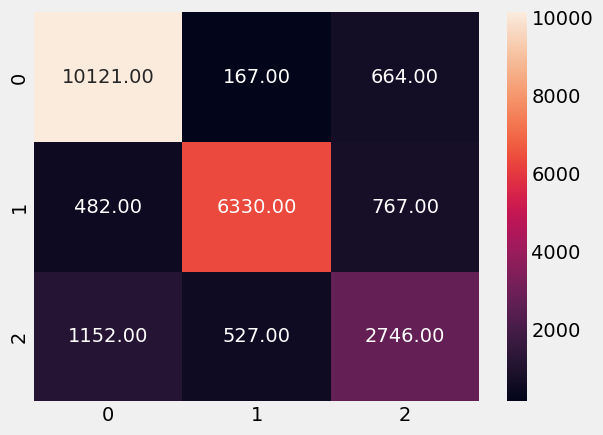

In [34]:
sns.heatmap(confusion_matrix(y_test, tuned_xgb_val_preds), annot = True, fmt = ".2f")

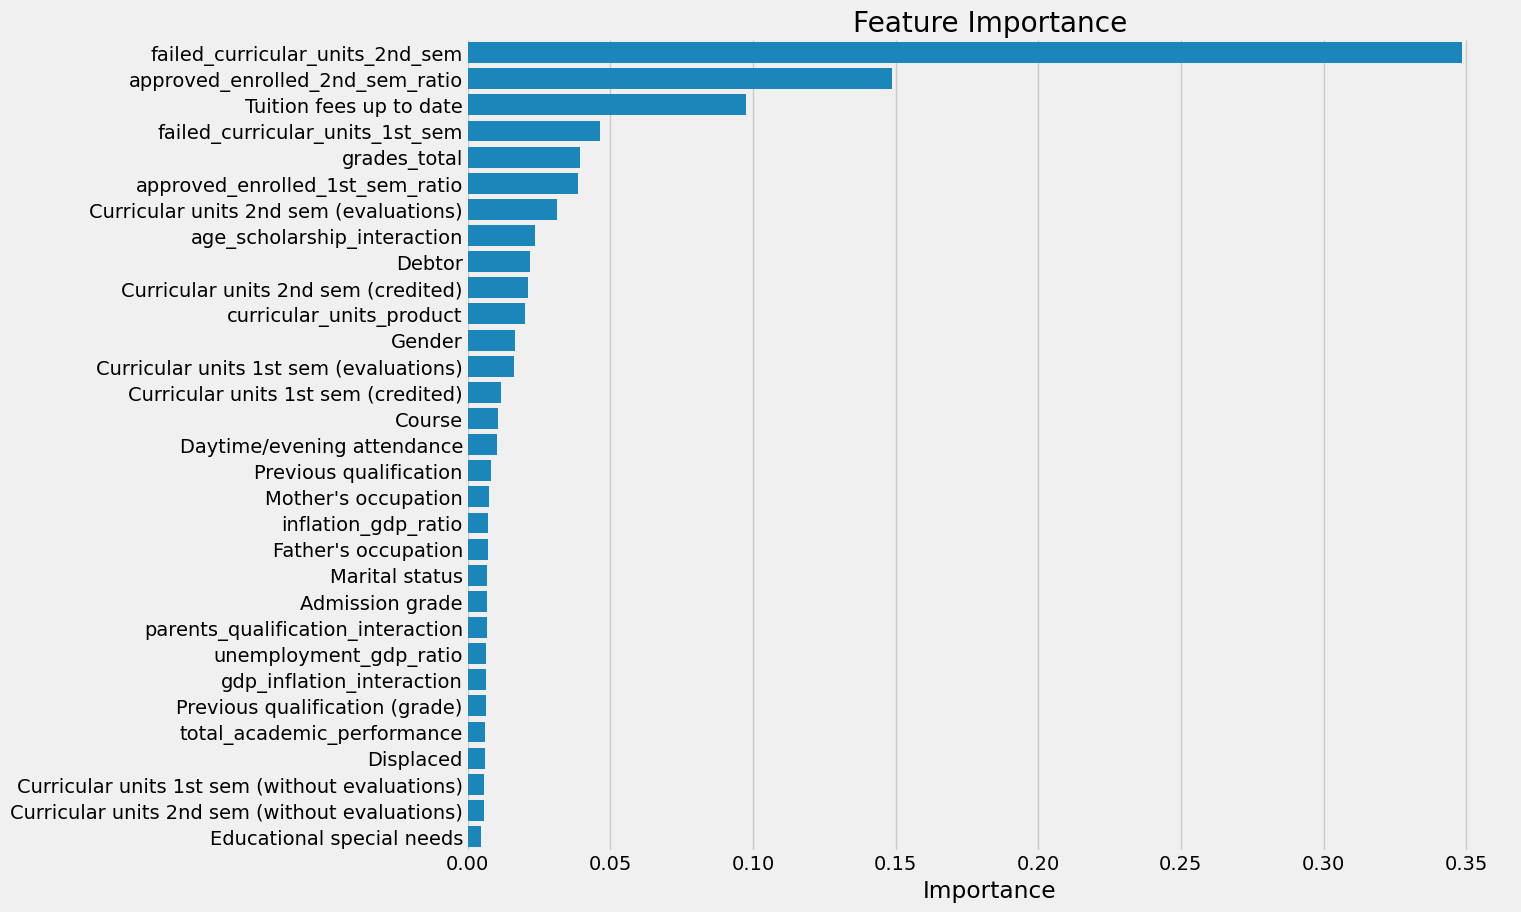

In [35]:
feature_importance = tuned_xgb_model.feature_importances_
feature_importance_df = pd.DataFrame({"Feature" : X_train.columns, "Importance" : feature_importance})
feature_importance_df = feature_importance_df.sort_values(by = "Importance", ascending = False)
plt.figure(figsize=(12, 10))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('')
sns.despine(left=True, bottom=True)
plt.show()

In [36]:
base_models = [
    ("gbc", GradientBoostingClassifier(n_estimators = 100, learning_rate = 0.1, max_depth = 3, random_state = 42)),
    ("bc", BaggingClassifier(n_estimators = 50, max_samples = 0.8, max_features = 0.8, random_state = 42)),
    ("edt", ExtraTreesClassifier(n_estimators = 100, max_depth = None, min_samples_split = 2, random_state = 42)),
    ('rf', RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, random_state=42)),
    ('ada', AdaBoostClassifier(n_estimators=50, learning_rate=1.0, algorithm='SAMME.R', random_state=42)),
    ('hgb', HistGradientBoostingClassifier(max_iter=100, learning_rate=0.1, max_leaf_nodes=31, random_state=42)),
    ('lgbm', LGBMClassifier(**{'n_estimators': 250, 'num_class': 3, 'verbosity': -1, 'random_state': 42, 
                               'learning_rate': 0.08, 'num_leaves': 40, 'min_data_in_leaf': 40, 'min_gain_to_split': 1.3739536396889442,
                               'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7})),
    ('xgb', XGBClassifier(**best_params_xgb_current, gpu_id=0, tree_method='gpu_hist', predictor='gpu_predictor',
                          eval_metric='merror', class_weight=class_weights_dict, random_state=42)),
    ('cat', CatBoostClassifier(**{'iterations': 1800, 'learning_rate': 0.048337853529415456, 'depth': 7, 
                                  'l2_leaf_reg': 5.240010375977423, 'random_state': 42}, logging_level='Silent'))
]

In [37]:
meta_model = LogisticRegression(random_state = 42)
stacking_model = StackingClassifier(estimators = base_models, final_estimator = meta_model, cv = 5, n_jobs = -1)

In [38]:
stacking_model.fit(X_train, y_train_new)

StackingClassifier(cv=5,
                   estimators=[('gbc',
                                GradientBoostingClassifier(random_state=42)),
                               ('bc',
                                BaggingClassifier(max_features=0.8,
                                                  max_samples=0.8,
                                                  n_estimators=50,
                                                  random_state=42)),
                               ('edt', ExtraTreesClassifier(random_state=42)),
                               ('rf', RandomForestClassifier(random_state=42)),
                               ('ada', AdaBoostClassifier(random_state=42)),
                               ('hgb',
                                HistGradientBoostingClassif...
                                              max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=6,
                                              max_leaves=None,
                                              min_child_weight=9, missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=4937, n_jobs=None, ...)),
                               ('cat',
                                <catboost.core.CatBoostClassifier object at 0x00000174A254EB90>)],
                   final_estimator=LogisticRegression(random_state=42),
                   n_jobs=-1)

E:\Anaconda\Lib\site-packages\xgboost\core.py:160: UserWarning:

[16:48:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"


E:\Anaconda\Lib\site-packages\xgboost\core.py:160: UserWarning:

[16:48:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be 

<Axes: >

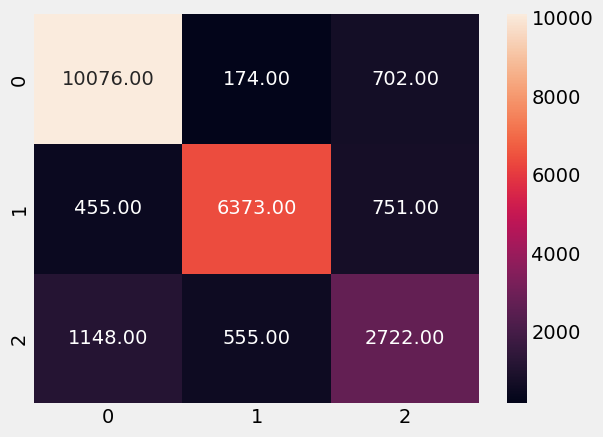

In [39]:
sns.heatmap(confusion_matrix(y_test, stacking_model.predict(X_test)), annot = True, fmt = ".2f")

In [40]:
ensemble_models = [
    ('gbc', GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)),
    ('bc', BaggingClassifier(n_estimators=50, max_samples=0.8, max_features=0.8, random_state=42)),
    ('edt', ExtraTreesClassifier(n_estimators=100, max_depth=None, min_samples_split=2, random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, random_state=42)),
    ('ada', AdaBoostClassifier(n_estimators=50, learning_rate=1.0, algorithm='SAMME.R', random_state=42)),
    ('hgb', HistGradientBoostingClassifier(max_iter=100, learning_rate=0.1, max_leaf_nodes=31, random_state=42)),
    ('xgb', XGBClassifier(**best_params_xgb_current, gpu_id=0, eval_metric='merror', class_weight=class_weights_dict, random_state=42)),
    ('log', LogisticRegression(penalty='l2', class_weight=class_weights_dict, random_state=42))
]
voting_model = VotingClassifier(estimators=ensemble_models, voting='soft', n_jobs = -1)

In [41]:
voting_model.fit(X_train, y_train_new)

VotingClassifier(estimators=[('gbc',
                              GradientBoostingClassifier(random_state=42)),
                             ('bc',
                              BaggingClassifier(max_features=0.8,
                                                max_samples=0.8,
                                                n_estimators=50,
                                                random_state=42)),
                             ('edt', ExtraTreesClassifier(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('ada', AdaBoostClassifier(random_state=42)),
                             ('hgb',
                              HistGradientBoostingClassifier(ran...
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=6,
                                            max_leaves=None, min_child_weight=9,
                                            missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=4937, n_jobs=None, ...)),
                             ('log',
                              LogisticRegression(class_weight={0: 0.7029932197784026,
                                                               1: 1.0083017077798861,
                                                               2: 1.7072289156626506},
                                                 random_state=42))],
                 n_jobs=-1, voting='soft')

<Axes: >

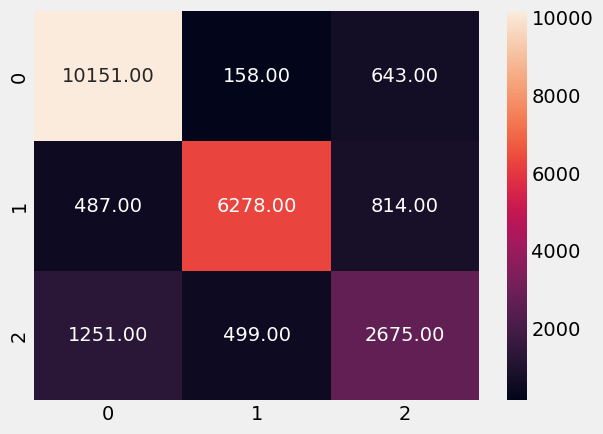

In [42]:
sns.heatmap(confusion_matrix(y_test, voting_model.predict(X_test)), annot = True, fmt = ".2f")

In [43]:
voting_model_val_preds = voting_model.predict(X_test)
voting_model_val_accuracy = accuracy_score(y_test, voting_model_val_preds)
print(voting_model_val_accuracy)

0.8322007318348145
